In [49]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE

## Training Dataset

Training Data Size: 1956
Training Data Distribution:
CLASS
1    1005
0     951
Name: count, dtype: int64


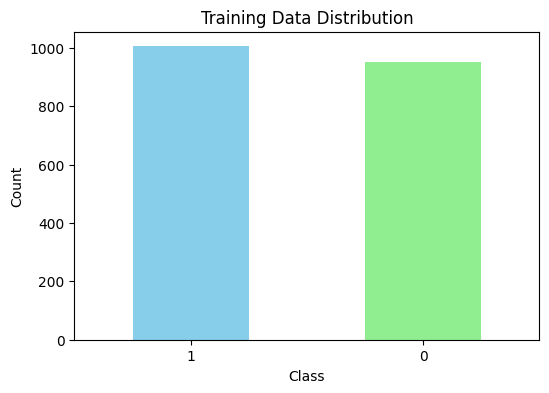

In [50]:


# Load your training dataset
# Using the uploaded 'Youtube-Spam-Dataset.csv' with columns 'CONTENT' and 'CLASS'
file_path = 'dataset/youtube_spam.csv'
train_data = pd.read_csv(file_path)
train_texts = train_data['CONTENT']
train_labels = train_data['CLASS']

# Display training data size and distribution
print(f'Training Data Size: {len(train_data)}')
print('Training Data Distribution:')
print(train_labels.value_counts())

# Plot the distribution of classes in the training dataset
plt.figure(figsize=(6, 4))
train_labels.value_counts().plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Training Data Distribution')
plt.xticks(rotation=0)
plt.show()


In [51]:
# Preprocessing function for text cleaning
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Stemming and Lemmatization functions
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_and_lemmatize(text):
    # Apply stemming and lemmatization
    words = text.split()
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


## Split Dataset Train Val Test

In [52]:
# Shuffle the dataset
train_data = train_data.sample(frac=1, random_state=42)
# Apply preprocessing to the dataset
train_texts = train_data['CONTENT'].apply(preprocess_text).apply(stem_and_lemmatize)
train_labels = train_data['CLASS']

# Split the data into training, validation, and test sets
X_train_texts, X_test_texts, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)
X_train_texts, X_val_texts, y_train, y_val = train_test_split(X_train_texts, y_train, test_size=0.2, random_state=42)

# Convert the text data into TF-IDF feature vectors, fitting only on the training data
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = tfidf_vectorizer.fit_transform(X_train_texts)
X_val = tfidf_vectorizer.transform(X_val_texts)
X_test = tfidf_vectorizer.transform(X_test_texts)


## Balancing Dataset SMOTE

In [53]:
# Balancing the training data using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


Balanced Training Data Size: 1298
Balanced Training Data Distribution:
{0: 649, 1: 649}


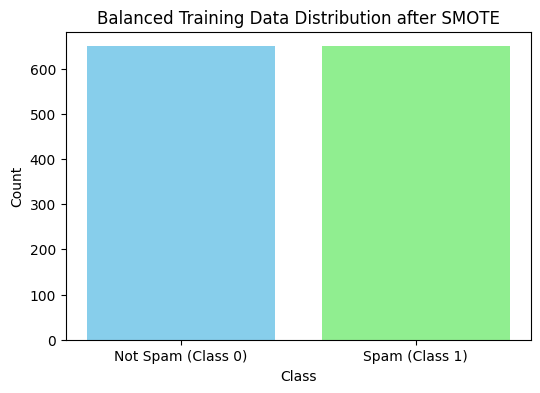

In [54]:

# Display balanced training data size and distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f'Balanced Training Data Size: {len(y_train)}')
print('Balanced Training Data Distribution:')
print(dict(zip(unique, counts)))

# Plot the distribution of classes in the balanced training dataset after SMOTE
plt.figure(figsize=(6, 4))
plt.bar(['Not Spam (Class 0)', 'Spam (Class 1)'], counts, color=['skyblue', 'lightgreen'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Balanced Training Data Distribution after SMOTE')
plt.xticks(rotation=0)
plt.show()

In [55]:
# Define the model and apply GridSearch for hyperparameter tuning
param_grid = {
    'alpha': [0.1, 0.5, 1.0]
}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_
print(f'Best Parameters from GridSearch: {grid_search.best_params_}')

# Display accuracy of the best model on training and validation sets
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
val_accuracy = accuracy_score(y_val, best_model.predict(X_val))
print(f'Training Accuracy with Best Parameters: {train_accuracy:.2f}')
print(f'Validation Accuracy with Best Parameters: {val_accuracy:.2f}')

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-validation Accuracy: {cv_scores.mean():.2f}')


Best Parameters from GridSearch: {'alpha': 0.5}
Training Accuracy with Best Parameters: 0.97
Validation Accuracy with Best Parameters: 0.89
Cross-validation Accuracy Scores: [0.86153846 0.86923077 0.84230769 0.89189189 0.85328185]
Mean Cross-validation Accuracy: 0.86


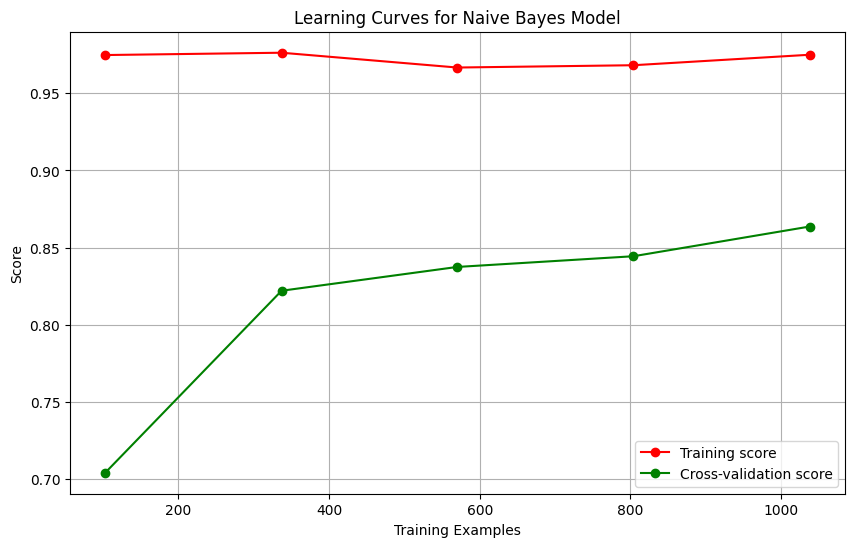

In [56]:
# Learning Curve Visualization
def plot_learning_curve(estimator, X, y, title="Learning Curves", cv=5):
    plt.figure(figsize=(10, 6))
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(best_model, X_train, y_train, title="Learning Curves for Naive Bayes Model")

In [57]:
# Save the best trained model and vectorizer for baseline testing with a different dataset
joblib.dump(best_model, 'spam_detection_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [58]:
# Load the new testing dataset for baseline testing
# Using the uploaded 'youtube_comments_i6IOiUi6IYY.xlsx'
test_file_path = 'youtube_comments_i6IOiUi6IYY.xlsx'
new_test_data = pd.read_excel(test_file_path)
new_test_texts = new_test_data['Comment']

# Apply preprocessing to the new testing dataset
new_test_texts = new_test_texts.apply(preprocess_text).apply(stem_and_lemmatize)

# Transform the new test data
X_new_test = tfidf_vectorizer.transform(new_test_texts)

# Predict labels for the new testing dataset
new_test_predictions = best_model.predict(X_new_test)
new_test_data['Prediction'] = new_test_predictions

# Save the predictions to an Excel file
new_test_data.to_excel('new_test_predictions.xlsx', index=False)

Test Accuracy: 0.88
Test Precision: 0.88
Test Recall: 0.88
Test F1 Score: 0.88
Confusion Matrix for Testing Dataset:
[[168  19]
 [ 30 175]]


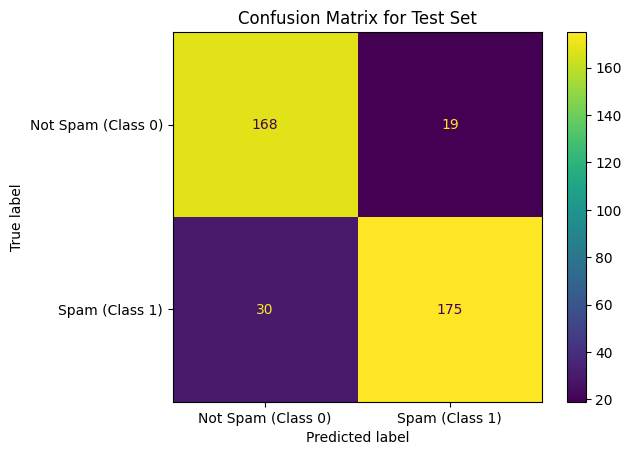

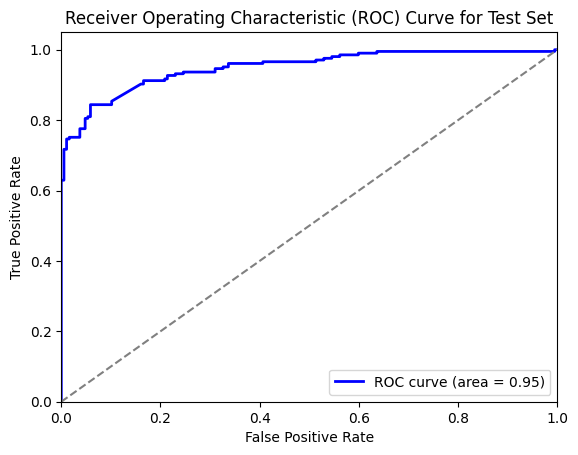

In [59]:
# Evaluate model performance on the test set
y_test_predictions = best_model.predict(X_test)
y_test_probabilities = best_model.predict_proba(X_test)[:, 1]  # Probability for class 1 (Spam)

# Evaluate the model performance
test_accuracy = accuracy_score(y_test, y_test_predictions)
test_precision = precision_score(y_test, y_test_predictions, average='weighted')
test_recall = recall_score(y_test, y_test_predictions, average='weighted')
test_f1 = f1_score(y_test, y_test_predictions, average='weighted')

print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Precision: {test_precision:.2f}')
print(f'Test Recall: {test_recall:.2f}')
print(f'Test F1 Score: {test_f1:.2f}')

# Confusion Matrix for the testing dataset
test_conf_matrix = confusion_matrix(y_test, y_test_predictions)
print('Confusion Matrix for Testing Dataset:')
print(test_conf_matrix)

# Display Confusion Matrix for the testing dataset
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Not Spam (Class 0)', 'Spam (Class 1)'])
disp_test.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()

# ROC/AUC Curve for Testing Dataset
fpr, tpr, _ = roc_curve(y_test, y_test_probabilities)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_test_probabilities))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Optionally, save the predictions to a CSV file
new_test_data.to_csv('new_test_predictions.csv', index=False)

Evaluating with test size: 0.2
Accuracy: 0.92
Precision: 0.93
Recall: 0.92
F1 Score: 0.92
Confusion Matrix for Testing Dataset:
[[33  1]
 [ 5 40]]


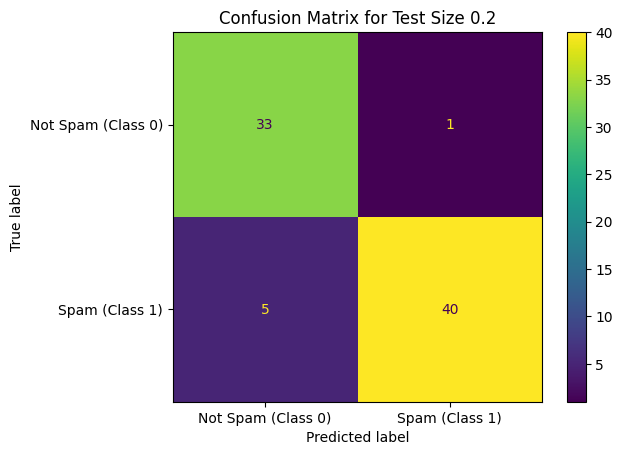

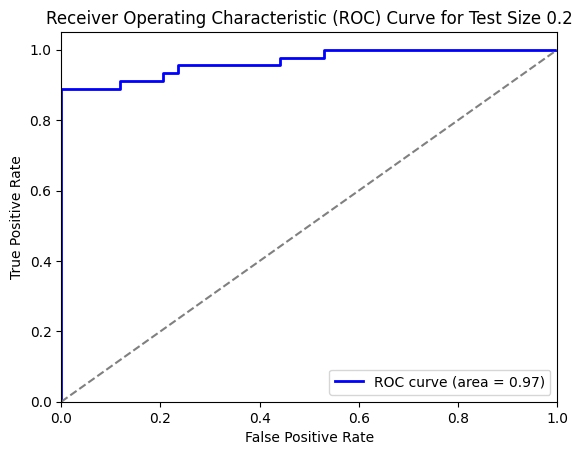

Evaluating with test size: 0.25
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Confusion Matrix for Testing Dataset:
[[40  2]
 [ 6 50]]


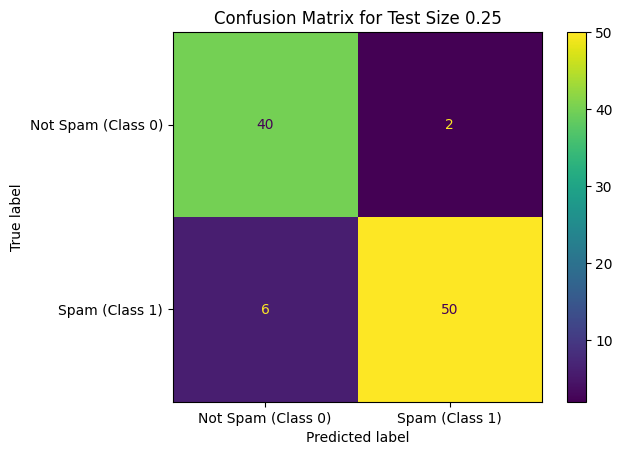

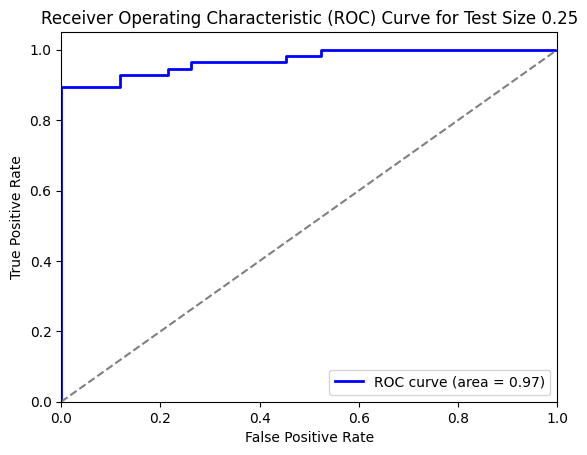

Evaluating with test size: 0.3
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Confusion Matrix for Testing Dataset:
[[50  3]
 [ 7 58]]


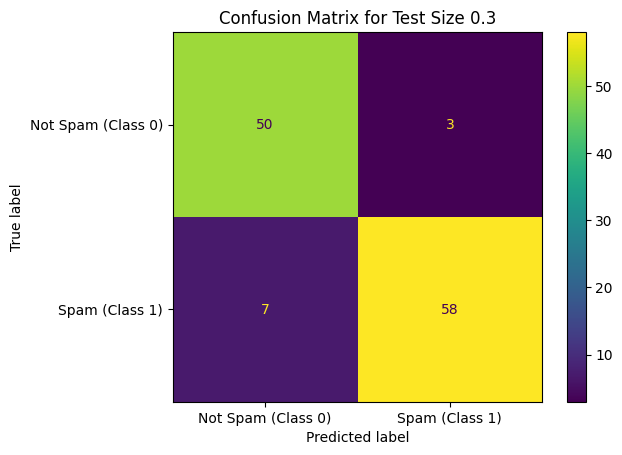

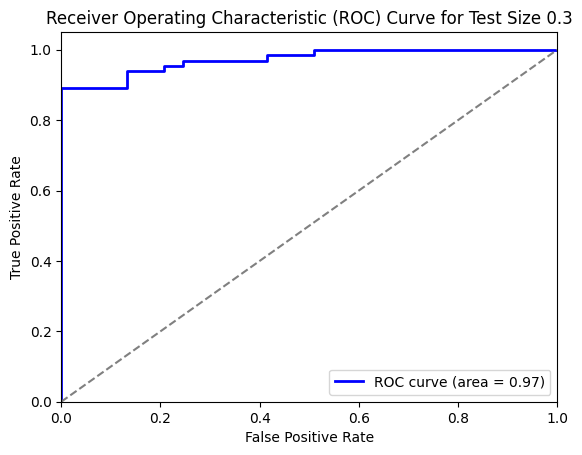

Evaluating with test size: 0.35
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Confusion Matrix for Testing Dataset:
[[59  3]
 [10 66]]


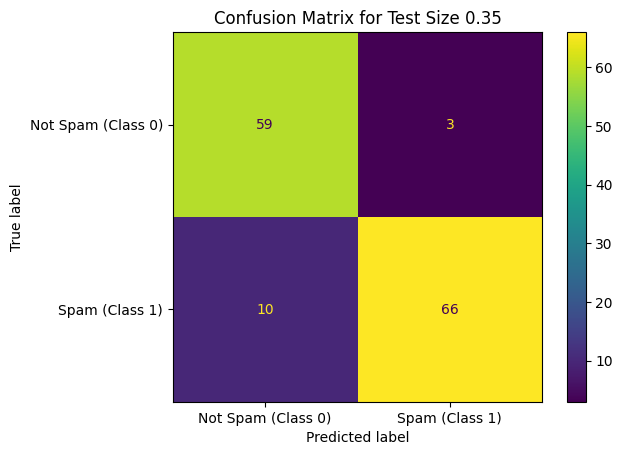

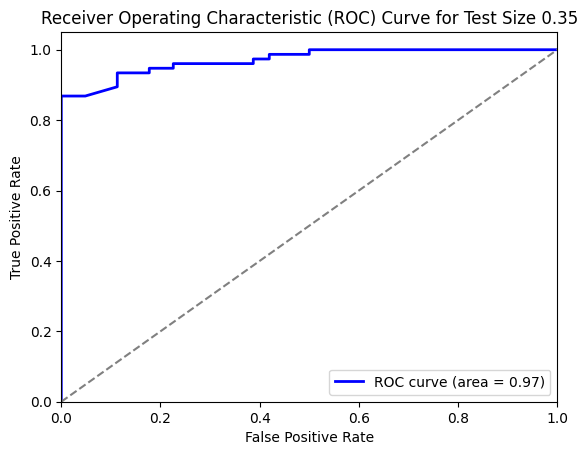

   Test Size  Accuracy  Precision    Recall  F1 Score
0       0.20  0.924051   0.929478  0.924051  0.924394
1       0.25  0.918367   0.922121  0.918367  0.918711
2       0.30  0.915254   0.917750  0.915254  0.915450
3       0.35  0.905797   0.910943  0.905797  0.906040


In [60]:
# Evaluate model performance with different test sizes for comparison
test_sizes = [0.2, 0.25, 0.3, 0.35]
# test_sizes = [0.2]
results = []

for test_size in test_sizes:
    print(f'Evaluating with test size: {test_size}')
    
    # Split the original test data into training and testing parts
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_test, y_test, test_size=test_size, random_state=42)
    
    # Predict using the best model on the split test set
    y_test_predictions_split = best_model.predict(X_test_split)
    y_test_probabilities_split = best_model.predict_proba(X_test_split)[:, 1]  # Probability for class 1 (Spam)
    
    # Evaluate the model performance
    test_accuracy = accuracy_score(y_test_split, y_test_predictions_split)
    test_precision = precision_score(y_test_split, y_test_predictions_split, average='weighted')
    test_recall = recall_score(y_test_split, y_test_predictions_split, average='weighted')
    test_f1 = f1_score(y_test_split, y_test_predictions_split, average='weighted')
    
    results.append({
        'Test Size': test_size,
        'Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1 Score': test_f1
    })
    
    print(f'Accuracy: {test_accuracy:.2f}')
    print(f'Precision: {test_precision:.2f}')
    print(f'Recall: {test_recall:.2f}')
    print(f'F1 Score: {test_f1:.2f}')
    
    # Confusion Matrix for the testing dataset
    test_conf_matrix = confusion_matrix(y_test_split, y_test_predictions_split)
    print('Confusion Matrix for Testing Dataset:')
    print(test_conf_matrix)
    
    # Display Confusion Matrix for the testing dataset
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Not Spam (Class 0)', 'Spam (Class 1)'])
    disp_test.plot()
    plt.title(f'Confusion Matrix for Test Size {test_size}')
    plt.show()
    
    # ROC/AUC Curve for Testing Dataset
    fpr, tpr, _ = roc_curve(y_test_split, y_test_probabilities_split)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test_split, y_test_probabilities_split))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for Test Size {test_size}')
    plt.legend(loc='lower right')
    plt.show()

# Display a summary comparison of different test sizes
results_df = pd.DataFrame(results)
print(results_df)

   Test Size  Accuracy  Precision    Recall  F1 Score
0       0.20  0.924051   0.929478  0.924051  0.924394
1       0.25  0.918367   0.922121  0.918367  0.918711
2       0.30  0.915254   0.917750  0.915254  0.915450
3       0.35  0.905797   0.910943  0.905797  0.906040


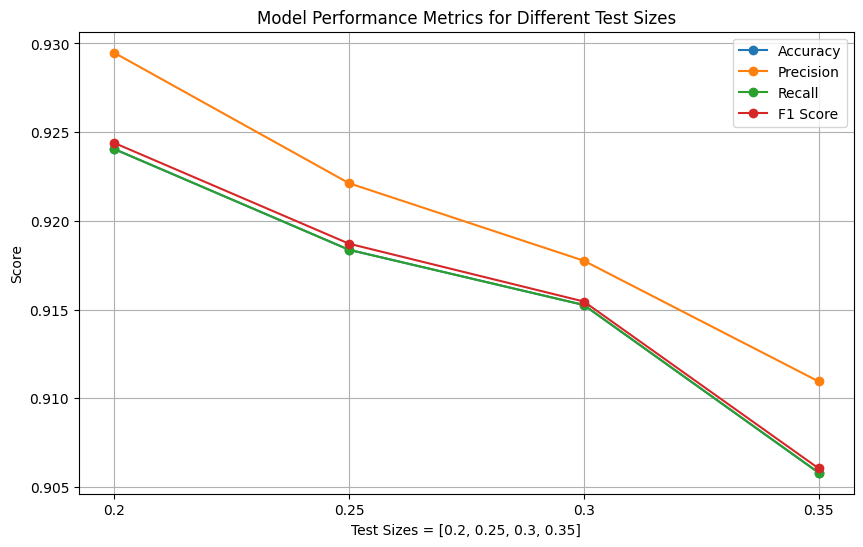

In [61]:
# Display a summary comparison of different test sizes
results_df = pd.DataFrame(results)
print(results_df)

# Visualization of the comparison using line chart
plt.figure(figsize=(10, 6))
plt.plot(results_df['Test Size'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['Test Size'], results_df['Precision'], marker='o', label='Precision')
plt.plot(results_df['Test Size'], results_df['Recall'], marker='o', label='Recall')
plt.plot(results_df['Test Size'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xticks(ticks=results_df['Test Size'], labels=test_sizes)
plt.xlabel('Test Sizes = [0.2, 0.25, 0.3, 0.35]')
plt.ylabel('Score')
plt.title('Model Performance Metrics for Different Test Sizes')
plt.legend()
plt.grid()
plt.show()


# Optionally, save the predictions to a CSV file
new_test_data.to_csv('new_test_predictions.csv', index=False)


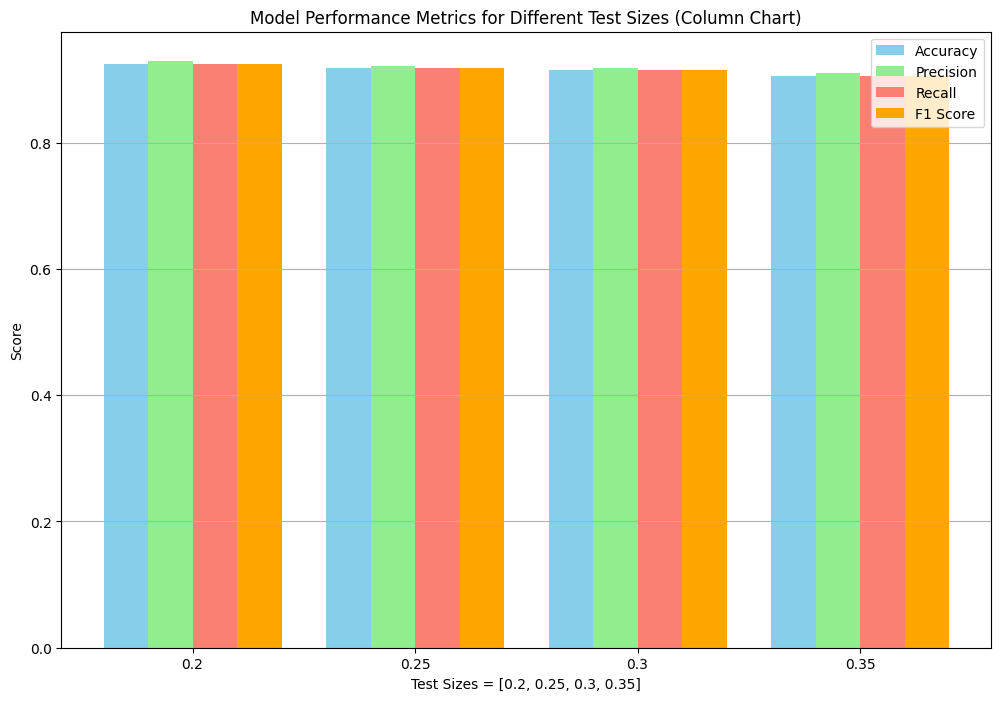

In [62]:
# Visualization of the comparison using column chart
plt.figure(figsize=(12, 8))
x = np.arange(len(results_df['Test Size']))
width = 0.2

plt.bar(x - 1.5 * width, results_df['Accuracy'], width, label='Accuracy', color='skyblue')
plt.bar(x - 0.5 * width, results_df['Precision'], width, label='Precision', color='lightgreen')
plt.bar(x + 0.5 * width, results_df['Recall'], width, label='Recall', color='salmon')
plt.bar(x + 1.5 * width, results_df['F1 Score'], width, label='F1 Score', color='orange')

plt.xticks(ticks=x, labels=test_sizes)
plt.xlabel('Test Sizes = [0.2, 0.25, 0.3, 0.35]')
plt.ylabel('Score')
plt.title('Model Performance Metrics for Different Test Sizes (Column Chart)')
plt.legend()
plt.grid(axis='y')
plt.show()


Evaluating with test size: 0.2
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
Confusion Matrix for Testing Dataset:
[[168  19]
 [ 30 175]]


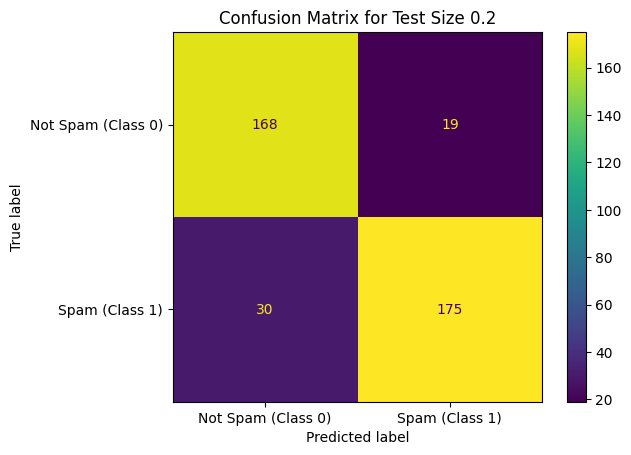

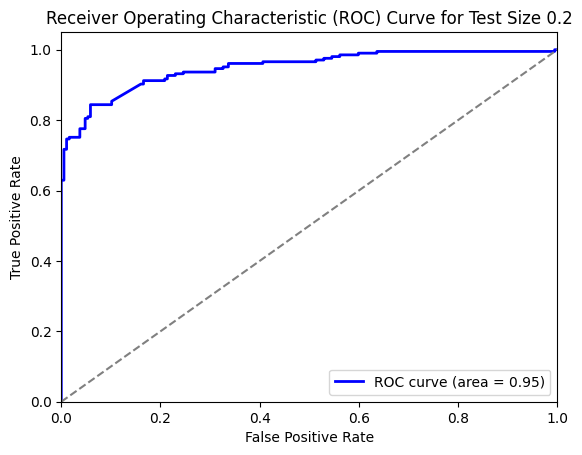


Evaluating with test size: 0.25
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1 Score: 0.89
Confusion Matrix for Testing Dataset:
[[218  21]
 [ 31 219]]


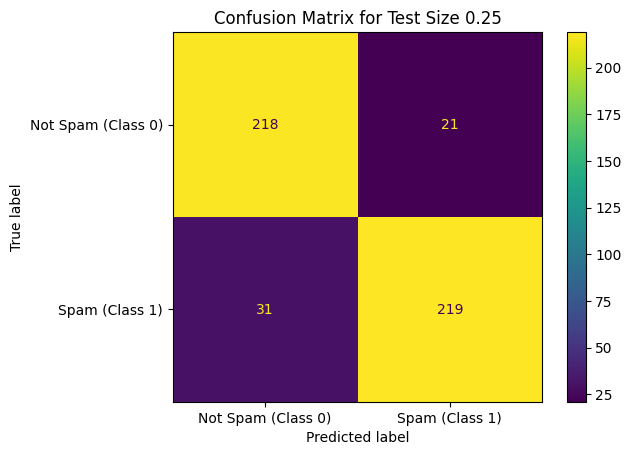

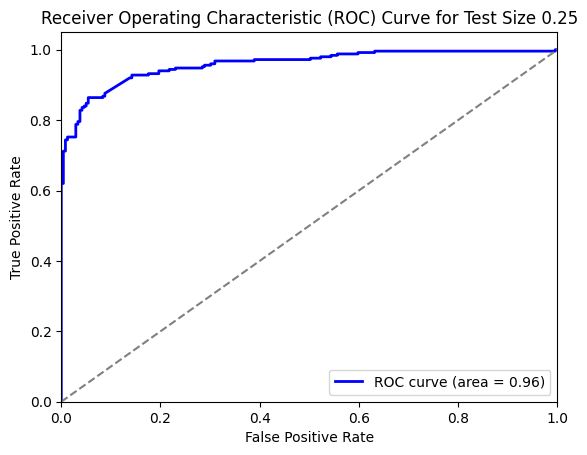


Evaluating with test size: 0.3
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91
Confusion Matrix for Testing Dataset:
[[258  23]
 [ 32 274]]


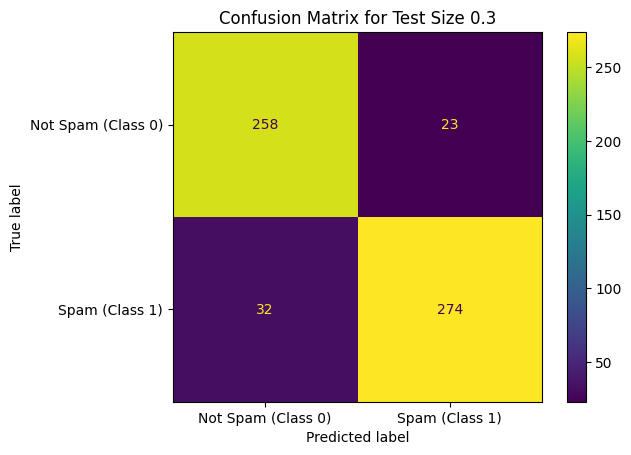

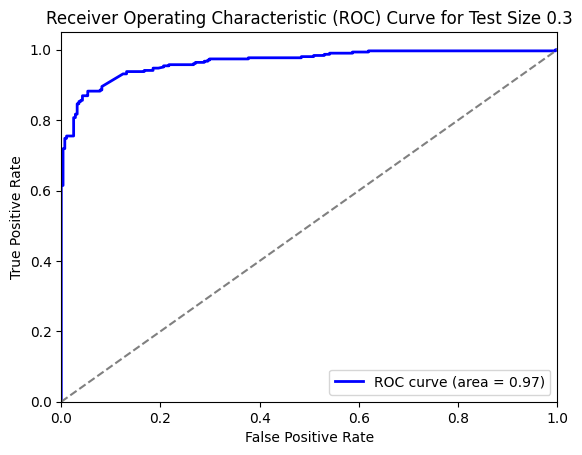


Evaluating with test size: 0.35
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92
Confusion Matrix for Testing Dataset:
[[308  23]
 [ 34 320]]


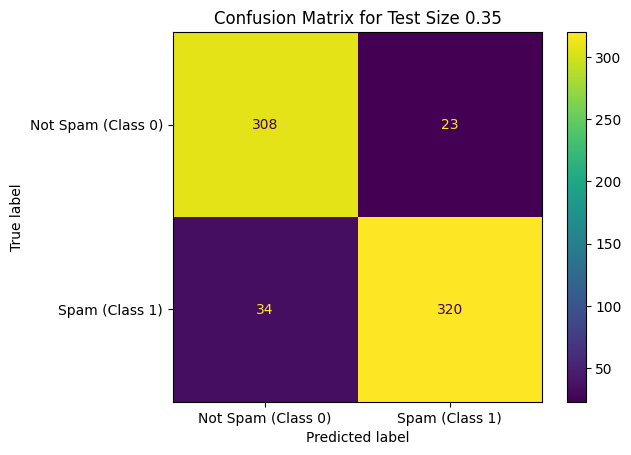

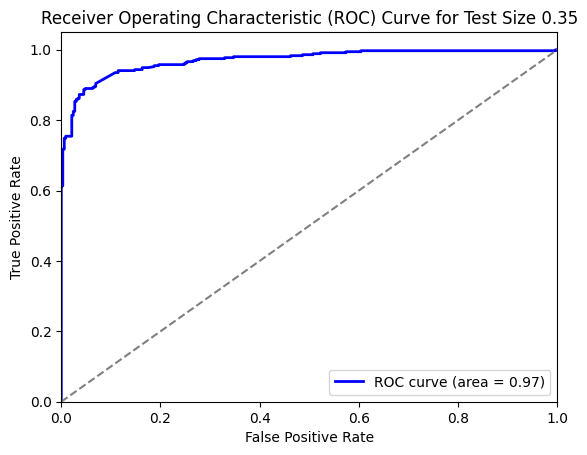

In [46]:
for test_size in test_sizes:
    print(f'\nEvaluating with test size: {test_size}')
    
    # Split the original dataset into different training and test sets
    _, X_test_texts, _, y_test = train_test_split(train_texts, train_labels, test_size=test_size, random_state=42)
    
    # Convert the text data into TF-IDF feature vectors using the saved vectorizer
    X_test = tfidf_vectorizer.transform(X_test_texts)
    
    # Predict using the best saved model on the test set
    y_test_predictions = best_model.predict(X_test)
    y_test_probabilities = best_model.predict_proba(X_test)[:, 1]  # Probability for class 1 (Spam)
    
    # Evaluate the model performance
    test_accuracy = accuracy_score(y_test, y_test_predictions)
    test_precision = precision_score(y_test, y_test_predictions, average='weighted')
    test_recall = recall_score(y_test, y_test_predictions, average='weighted')
    test_f1 = f1_score(y_test, y_test_predictions, average='weighted')
    
    results.append({
        'Test Size': test_size,
        'Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1 Score': test_f1
    })
    
    print(f'Accuracy: {test_accuracy:.2f}')
    print(f'Precision: {test_precision:.2f}')
    print(f'Recall: {test_recall:.2f}')
    print(f'F1 Score: {test_f1:.2f}')
    
    # Confusion Matrix for the testing dataset
    test_conf_matrix = confusion_matrix(y_test, y_test_predictions)
    print('Confusion Matrix for Testing Dataset:')
    print(test_conf_matrix)
    
    # Display Confusion Matrix for the testing dataset
    disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Not Spam (Class 0)', 'Spam (Class 1)'])
    disp_test.plot()
    plt.title(f'Confusion Matrix for Test Size {test_size}')
    plt.show()
    
    # ROC/AUC Curve for Testing Dataset
    fpr, tpr, _ = roc_curve(y_test, y_test_probabilities)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_test_probabilities))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for Test Size {test_size}')
    plt.legend(loc='lower right')
    plt.show()